In [38]:
import torch
flag = torch.cuda.is_available()
if flag:
    print("CUDA可使用")
else:
    print("CUDA不可用")

ngpu= 1
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print("驱动为：",device)
print("GPU型号： ",torch.cuda.get_device_name(0))

CUDA可使用
驱动为： cuda:0
GPU型号：  GeForce GTX 1050 Ti


In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import matplotlib.pyplot as plt #数据可视化
import numpy as np 
from PIL import Image
from torchvision import datasets, transforms
from torchsummary import summary #从 torchsummary里导入 summary，打印显示网络结构和参数

In [40]:
batch_size=128
# 将数据集合下载到指定目录下,这里的transform表示，数据加载时所需要做的预处理操作
# 加载训练集合
train_dataset=torchvision.datasets.MNIST(
    root='.data',
    train=True,
    transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Resize(96),    # 其实网络没有固定尺寸，只是改成固定尺寸（前人算好了）方便计算
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]),#转化为tensor且数据标准化注意在FC中我们未做数据增强
    download=True)
# 加载测试集合
test_dataset=torchvision.datasets.MNIST(
    root='.data',
    train=False,
    transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Resize(96),    #   改变符合模型的尺寸就可以套用模板
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]),
    download=True)

train_loader=torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size, #一个批次的大小为128张
        shuffle=True  #随机打乱
    
        )

test_loader=torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        shuffle=True
        )

In [41]:
print('len(train_loader)={}'.format(len(train_loader))) 
print('len(test_loader)={}'.format(len(test_loader))) 

len(train_loader)=469
len(test_loader)=79


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


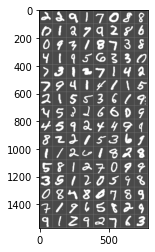

In [42]:
# 展示图像 
# 显示一张图片
def imshow(img):
    img = img / 2 + 0.5      # 逆归一化
    npimg = img.numpy()      # 将张量转换成numpy数组
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # transpose交换维度（0，1，2）转换为（1，2，0） imshow画图
    plt.show()               # 显示图片
    
#
# 得到一些随机训练图像
dataiter = iter(train_loader) # 生成迭代器 
images, labels = dataiter.next()

# 显示图像
imshow(torchvision.utils.make_grid(images))#生成网格

In [43]:
class Inception(nn.Module):
    # c1--c4是每条路径的输出通道数
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # 线路1，单1x1卷积层
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # 线路2，1x1卷积层后接3x3卷积层
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # 线路3，1x1卷积层后接5x5卷积层
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # 线路4，3x3最大汇聚层后接1x1卷积层
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)
        
    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # 在通道维度上连结输出
        return torch.cat((p1, p2, p3, p4), dim=1)
class GoogleNet(torch.nn.Module):
    def __init__(self):
        super(GoogleNet,self).__init__()
        self.block1=b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        self.block2=nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        self.block3=nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        self.block4=nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        self.block5=nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten()) 
    def forward(self,x):
        x=self.block1(x)
        x=self.block2(x)
        x=self.block3(x)
        x=self.block4(x)
        x=self.block5(x)        
        return x

In [44]:
model = GoogleNet().to(device)
model

GoogleNet(
  (block1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Inception(
      (p1_1): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (p2_1): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (p2_2): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (p3_1): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
      (p3_2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (p4_1): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
      (p4_2): Conv2

In [45]:
criterion = nn.CrossEntropyLoss()  #交叉熵损失函数，一般分类问题都用 one-hot + Cross-entropy 回归问题 用MSE
learning_rate = 0.01 #设置学习率为0.01
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)# 定义 Adam 优化器用于梯度下降 当然也可以用SGD
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,momentum = 0.9)#moentum是动量可以让曲线更加平滑,不行
# optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)
# #设置学习率衰减
# schedular=torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.998) 不是很好
# len(train_loader) # 一共有469个batch
# len(train_loader) # 一共有469个batch

In [46]:
def train(epoch):
    run_loss = 0.0
    for batch_idx, data in enumerate(train_loader, 0):#循环次数batch_idx的最大循环值 +1 = (MNIST数据集样本总数60000/ BATCH_SIZE )
        inputs, target = data
        inputs, target = inputs.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, target)
        loss.backward()#反向计算梯度
        optimizer.step()#优化参数
        run_loss += loss.item()
        if batch_idx % 200 == 199:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, batch_idx + 1, run_loss /200))
            run_loss = 0.0

In [47]:
def test():
    correct = 0
    total = 0
    with torch.no_grad():#此时已经不需要计算梯度，也不会进行反向传播
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device) #将数据转移到cuda上
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)# 将输出结果概率最大的作为预测值，找到概率最大的下标,输出最大值的索引位置
            total += labels.size(0)
            correct += (predicted == labels).sum().item()#正确率累加
    print('accuracy on test set: %d %% ' % (100 * correct / total))
    return correct / total

[1,   200] loss: 5.063
[1,   400] loss: 3.987
accuracy on test set: 11 % 
[2,   200] loss: 3.973
[2,   400] loss: 4.017
accuracy on test set: 10 % 
[3,   200] loss: 3.993
[3,   400] loss: 3.997
accuracy on test set: 11 % 
[4,   200] loss: 3.996
[4,   400] loss: 3.989
accuracy on test set: 11 % 
[5,   200] loss: 3.983
[5,   400] loss: 3.998
accuracy on test set: 11 % 
[6,   200] loss: 3.995
[6,   400] loss: 3.979
accuracy on test set: 10 % 
[7,   200] loss: 3.995
[7,   400] loss: 4.001
accuracy on test set: 11 % 
[8,   200] loss: 3.989
[8,   400] loss: 3.997
accuracy on test set: 11 % 
[9,   200] loss: 4.006
[9,   400] loss: 3.973
accuracy on test set: 10 % 
[10,   200] loss: 4.017
[10,   400] loss: 3.963
accuracy on test set: 11 % 


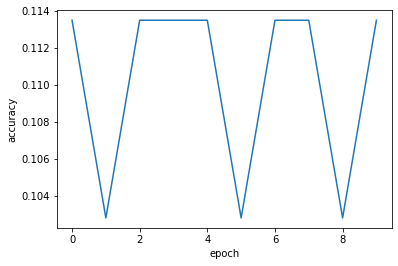

In [48]:
epoch_list = []
acc_list = []
for epoch in range(10):
    train(epoch)
    acc = test()
    epoch_list.append(epoch)
    acc_list.append(acc)
plt.plot(epoch_list, acc_list)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()